# Lesson 6: A Step-by-Step Guide to Segment Satellite Images with SAMGeo!

In this notebook you will learn how to segment satellite images through SAMGeo (Segment anything for geospatial data) model (https://samgeo.gishub.org/). The SAMGeo model is an adaptation of the Meta AI Segment Anything model (https://github.com/facebookresearch/segment-anything) to easy its use over geospatial data. It could be used to segment, delineate, or label landforms efficiently when using large-size geospatial raster images.

SAM model has the ability to perform complex image segmentation tasks with unprecedented precision and versatility.

Here are some key innovations of the SAM model:

- Zero-shot inference capabilities: SAM can accurately segment images without prior specific training, a task that traditionally requires tailored models.

- Inspired by NLP foundation models: The creators of SAM took inspiration from recent developments in natural language processing (NLP) with foundation models like GPT and BERT.

- Ability to process multiple prompts: You can hover or click on elements, drag boxes around them, automatically segment everything, and create custom masks or cut-outs.

In [1]:
# import libraries

In [2]:
# uncomment if leafmap is missing
# !pip install leafmap

In [3]:
# uncomment if torch is missing
# !pip install torchgeo

In [4]:
# uncomment if samgeo is missing
# !pip install segment-geospatial

In [2]:
import os
from IPython.display import display
import torch
import leafmap
import rasterio
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

In [3]:
# interactive plotting

In [4]:
# create a basemap
# zoom: The initial zoom level of the map
# height: The height of the map in pixels. In this case, it's set to "400px"
m = leafmap.Map(center=[41.8952, 12.4922], zoom=18, height="400px")
# "Google Satellite" refers to a satellite imagery basemap provided by Google
m.add_basemap("Google Satellite")
# display the map
m

Map(center=[41.8952, 12.4922], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [5]:
# Check if the Leafmap Map object m has a user-defined region of interest (ROI) bounds set. 
# If an ROI is set, it retrieves the bounds using m.user_roi_bounds(). 
# If no ROI is set, it assigns a default bounding box to the variable bbox
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else: 
    bbox = [12.4950, 41.8952, 12.5022, 41.9002]

In [6]:
# show used bbx
bbox

[12.495, 41.8952, 12.5022, 41.9002]

In [7]:
# The tms_to_geotiff function generates a GeoTIFF image based on the specified TMS source, bounding box, and zoom level. 
# The resulting GeoTIFF image will be saved with the filename "satellite.tif". 
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=18, source="Satellite", overwrite=True)

Downloaded image 01/30
Downloaded image 02/30
Downloaded image 03/30
Downloaded image 04/30
Downloaded image 05/30
Downloaded image 06/30
Downloaded image 07/30
Downloaded image 08/30
Downloaded image 09/30
Downloaded image 10/30
Downloaded image 11/30
Downloaded image 12/30
Downloaded image 13/30
Downloaded image 14/30
Downloaded image 15/30
Downloaded image 16/30
Downloaded image 17/30
Downloaded image 18/30
Downloaded image 19/30
Downloaded image 20/30
Downloaded image 21/30
Downloaded image 22/30
Downloaded image 23/30
Downloaded image 24/30
Downloaded image 25/30
Downloaded image 26/30
Downloaded image 27/30
Downloaded image 28/30
Downloaded image 29/30
Downloaded image 30/30
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


In [8]:
# open downloaded raster and save it
with rasterio.open("satellite.tif") as src:
    raster = src.read()
    print(raster.shape)

(3, 1252, 1342)


The **TMS** stands for **Tile Map Service**, is a standard for serving maps on the internet. It defines a way to divide the world into a set of tiles (small square images) at different zoom levels. These tiles can be pre-rendered and stored on a server, and when a map is requested, the server can quickly serve the appropriate tiles to the client based on the requested location and zoom level.

Here are some key concepts related to TMS:

- Tile Pyramid:

TMS organizes the world into a pyramid of tiles, with each level of the pyramid representing a different zoom level. The top level (zoom level 0) contains a single tile that covers the entire world. As you zoom in, each tile is divided into a grid of four tiles, and this subdivision continues as you zoom further.

- Coordinate System:

TMS uses a coordinate system where the origin (0,0) is at the top-left corner of the map. The x-axis increases as you move to the right, and the y-axis increases as you move down. This is different from some other coordinate systems used in web mapping, such as the one used by Google Maps, which has its origin at the bottom-left corner.
Tile URLs:

- URL

Each tile in the TMS pyramid is uniquely identified by its zoom level, x-coordinate, and y-coordinate. The URL for a tile typically follows a pattern like http://example.com/{zoom}/{x}/{y}.png, where {zoom}, {x}, and {y} are placeholders for the zoom level and coordinates of the tile.

In [9]:
# set last layer visibility to false
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(center=[41.8952, 12.4922], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

Different checkpoints for the trained SamModel are available and can be found in the original project https://github.com/facebookresearch/segment-anything#model-checkpoints

If the checkpoint is not found the model b checkpoint will be downladed.

In [10]:
# This cell may need several minutes to run
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=None,
)

# Generate masks

In [11]:
# Generate masks for the input image. Generated masks are stored on the disk with the name masks.tif
sam.generate(image, output="masks.tif", foreground=True, unique=True)

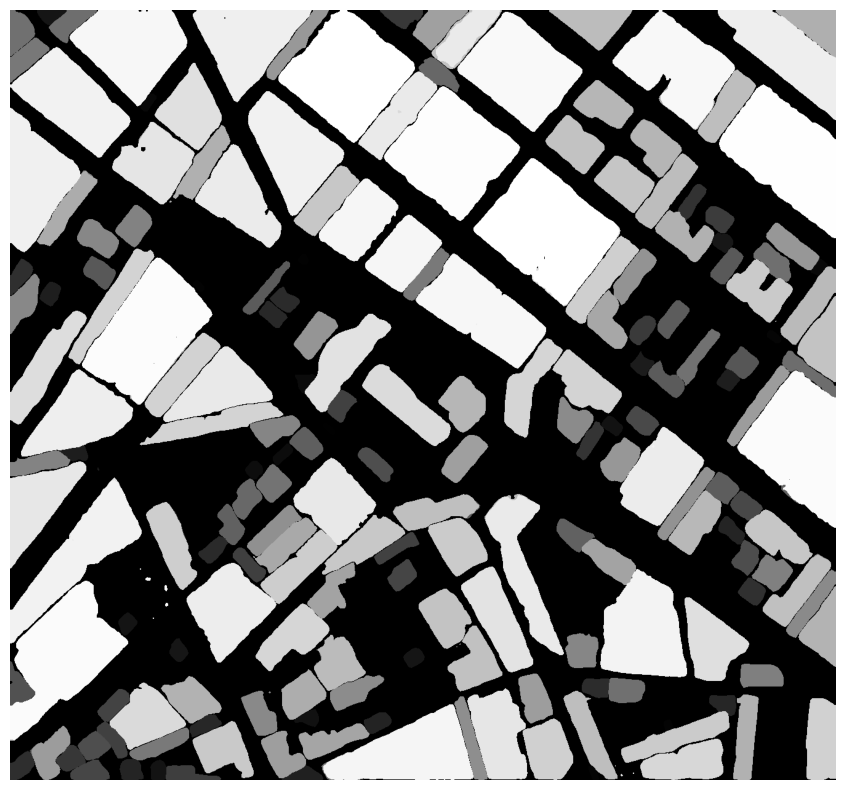

In [12]:
# show mask calculated previosly with unique values
sam.show_masks(cmap="binary_r")

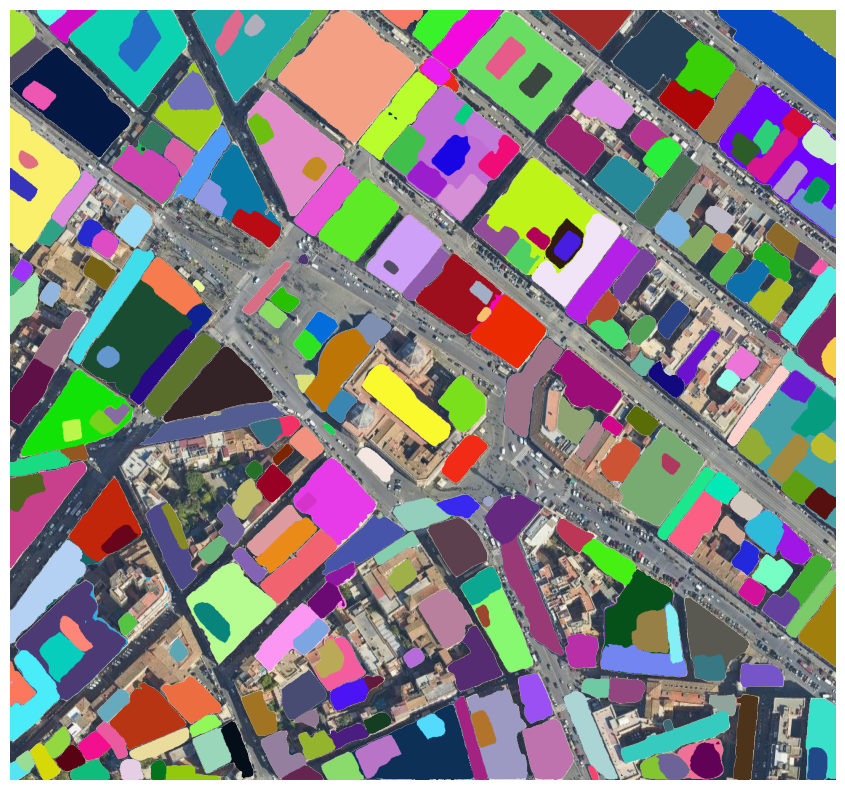

In [13]:
# show annotations i.e. masks overlaid with the satellite image
sam.show_anns(axis="off", alpha=1, output="annotations.tif")


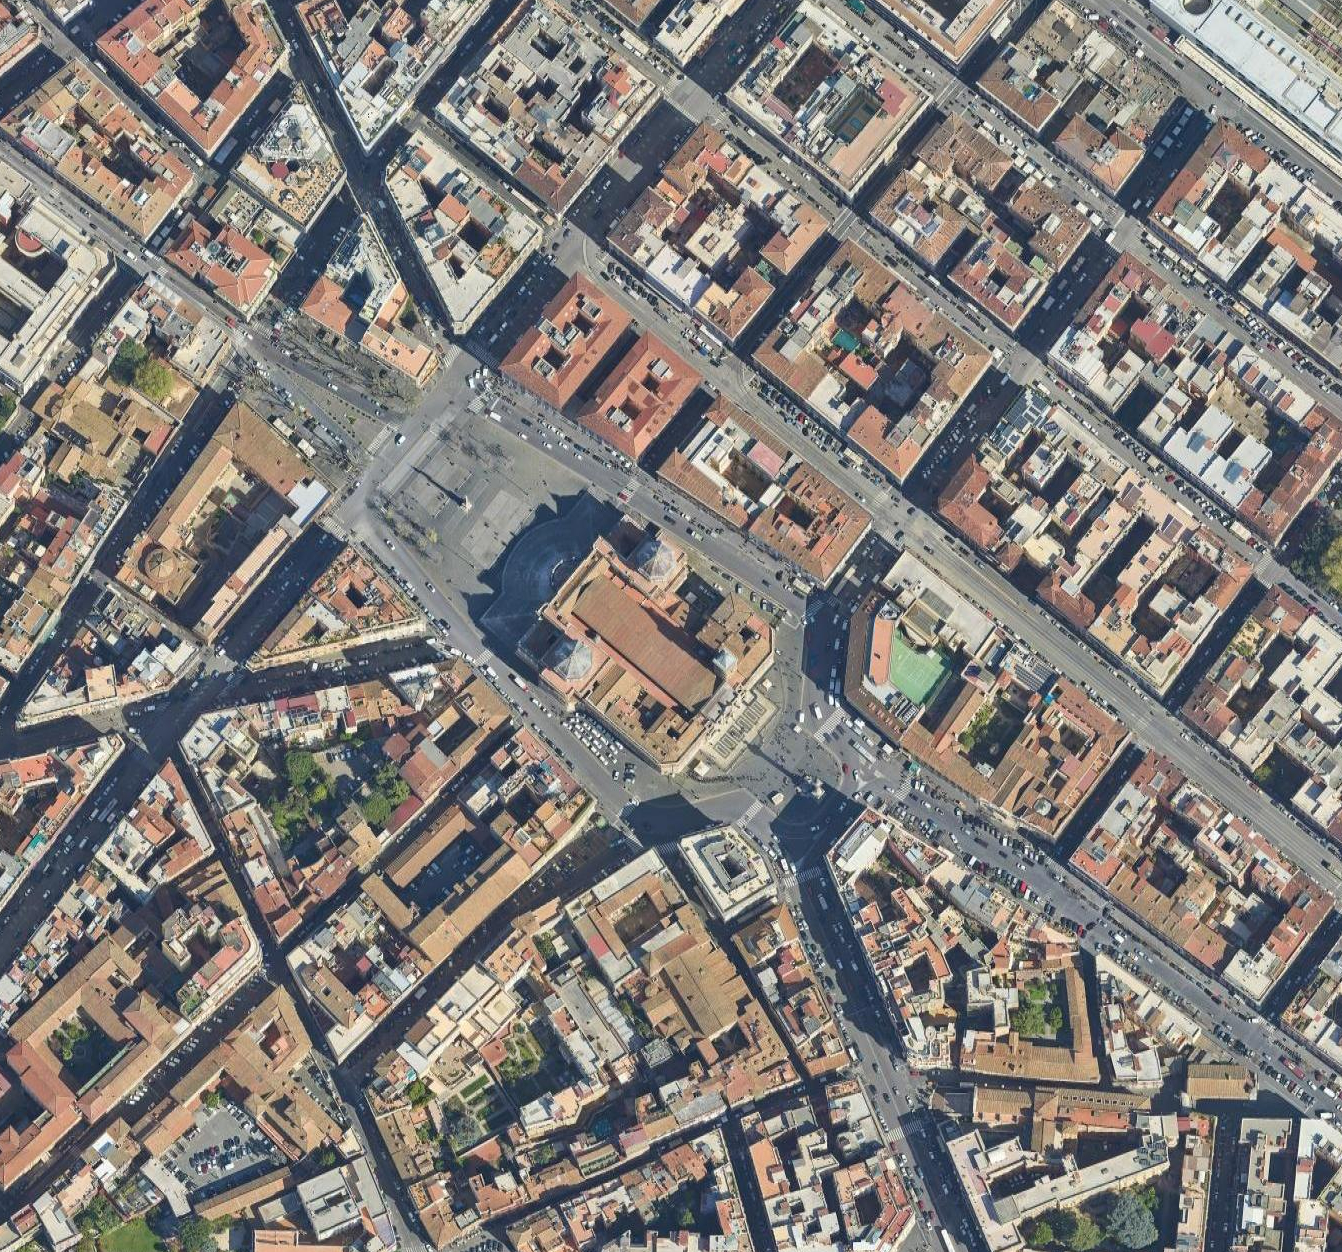
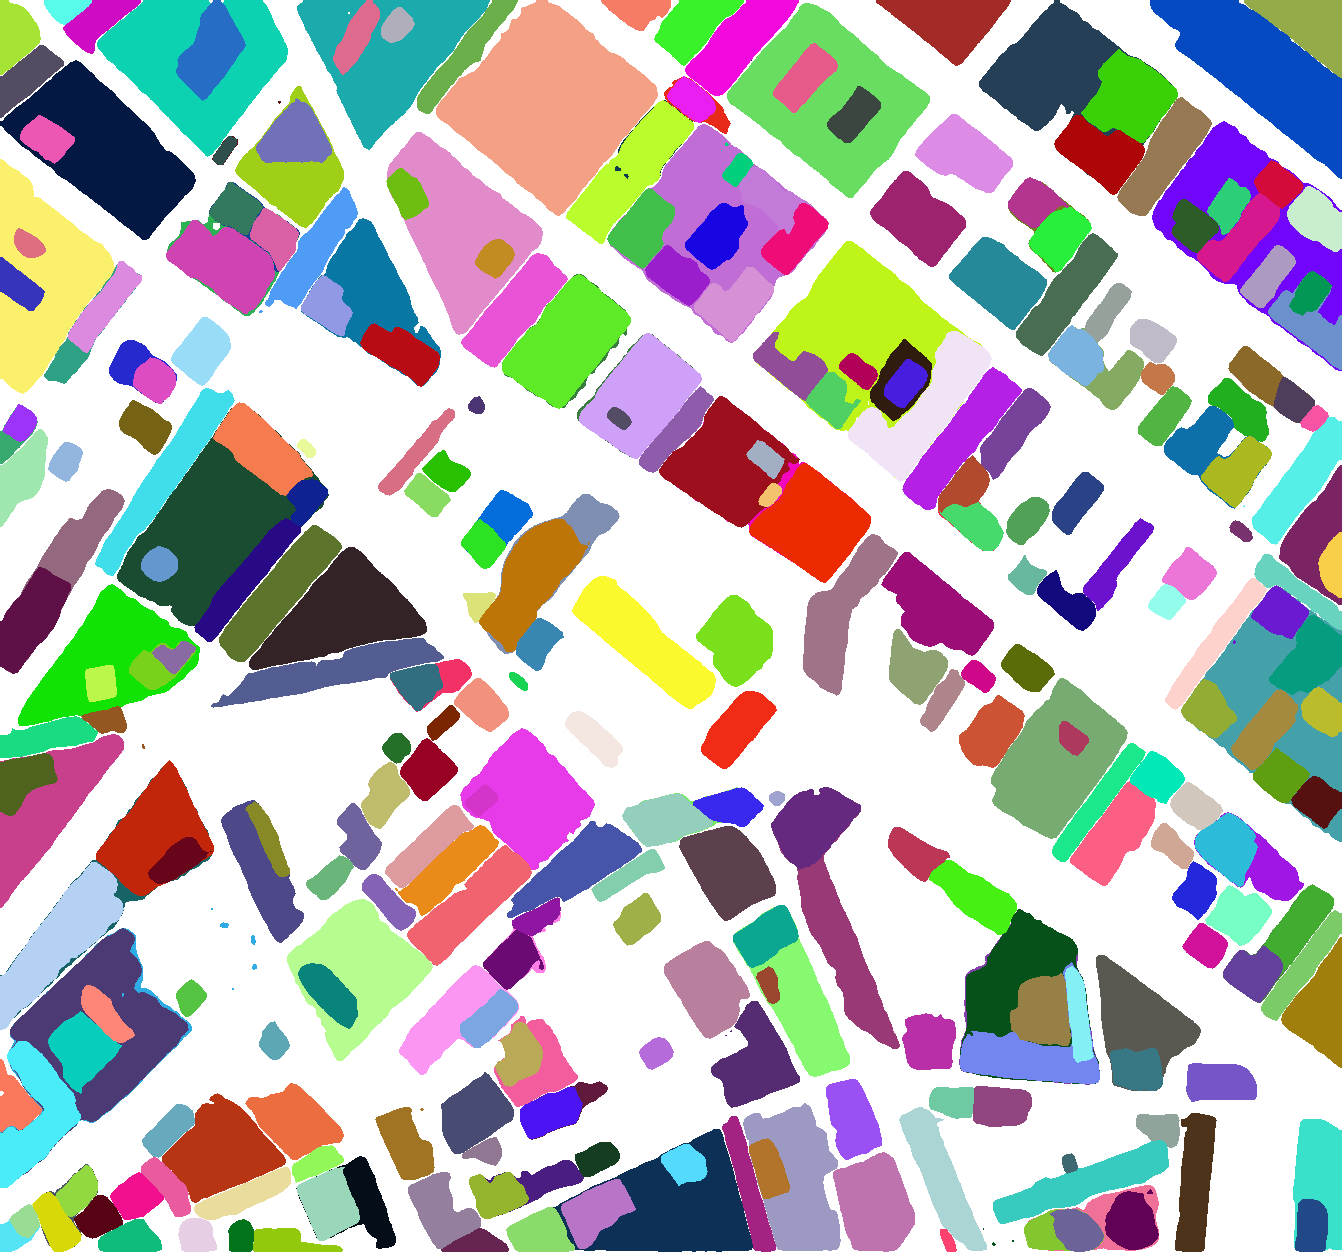

In [14]:
# compare images (sometimes this cell may not work, in that case you need to restart the kernel)
# you can scroll the vertical line
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

In [15]:
# overlap generated mask (with random colors) with the basemap
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Map(bottom=6234599.0, center=[41.897699999999986, 12.498599999999998], controls=(ZoomControl(options=['positio…

In [16]:
# convert masks to vector format
sam.tiff_to_vector("masks.tif", "masks.gpkg")

In [17]:
# several parameters can be assed to the SamGeo model, here there's an example
# further information for each param can be found there https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py#L35

In [18]:
sam_kwargs = {
    "points_per_side": 64, 
    "pred_iou_thresh": 0.9,
    "stability_score_thresh": 0.90,
    "crop_n_layers": 2,
    "crop_n_points_downscale_factor": 3,
    "min_mask_region_area": 90,
}

In [19]:
sam = SamGeo(
    model_type="vit_b",
    sam_kwargs=sam_kwargs,
)

Model checkpoint for vit_b not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth
100%|██████████| 375M/375M [00:44<00:00, 8.44MB/s] 


In [20]:
# Uncomment next cells to repeat the mask generation with this new params and compare the results

In [21]:
#sam.generate(image, output="masks2.tif", foreground=True)

In [22]:
#sam.show_masks(cmap="binary_r")

In [23]:
#sam.show_anns(axis="off", opacity=1, output="annotations2.tif")

In [24]:
#leafmap.image_comparison(
#    "satellite.tif",
#    "annotations.tif",
#    label1="Satellite Image",
#    label2="Image Segmentation",
#)

In [25]:
#overlay_images(image, "annotations2.tif", backend="TkAgg")